In [1]:
import os
import numpy as np

from scipy.signal.windows import tukey
import astropy
import astropy.units as u
from astropy.table import QTable
from astropy.nddata import StdDevUncertainty
from astropy.modeling.polynomial import Chebyshev1D
from astropy import constants as const
from astropy.io import fits, ascii
from astropy.wcs import WCS

import specutils
from specutils.fitting import continuum, find_lines_threshold, find_lines_derivative
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler, SplineInterpolatedResampler, LinearInterpolatedResampler
from specutils.analysis import correlation
from specutils import SpectralRegion
from specutils.manipulation import extract_region
from specutils.manipulation import linear_exciser
from specutils.manipulation import noise_region_uncertainty
from specutils.manipulation import gaussian_smooth, convolution_smooth

# Check versions
print("Numpy: ",np.__version__)
print("Astropy: ",astropy.__version__)
print("Specutils: ",specutils.__version__)
print("")
print("They should be:")
print("Numpy:  1.18.1")
print("Astropy:  4.0")
print("Specutils:  1.0")

Numpy:  1.22.3
Astropy:  5.0.2
Specutils:  1.7.0

They should be:
Numpy:  1.18.1
Astropy:  4.0
Specutils:  1.0


In [2]:
import matplotlib.pyplot as plt

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version if you want interactive plots
# %matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

In [3]:
# Files are on box

# Observation and weight.
file1d = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/redshift_crosscorr/legac_M1_v3.7_spec1d_130902.fits'
file1dwht = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/redshift_crosscorr/legac_M1_v3.7_wht1d_130902.fits'
# Template.
template_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/redshift_crosscorr/00006.dat'

# Plot limits
sp_xlim = [3000., 9000.]

In [4]:
# Observation
hdu1d = fits.open(file1d)
hdu1dwht = fits.open(file1dwht)

flux = hdu1d[0].data
wht = hdu1dwht[0].data
unc = 1./ np.sqrt(wht)
wave = WCS(hdu1d[0]).pixel_to_world(np.arange(len(hdu1d[0].data)), 0)[0]

spec_unit = u.Unit('10^-19 erg s^-1 cm^-2 angstrom^-1')
dataspec = QTable([wave*u.angstrom, flux*spec_unit, wht, unc*spec_unit], 
                   names=('wavelength','flux','weight','uncertainty'))
dataspec_sub = dataspec[dataspec['weight']>0.]
dataspec_sub

/var/folders/z6/bz261yzj6xgdy20gz4lpfn4r00018h/T/ipykernel_2469/3474148523.py:7: RuntimeWarning: divide by zero encountered in true_divide
  unc = 1./ np.sqrt(wht)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


wavelength,flux,weight,uncertainty
Angstrom,1e-19 erg / (Angstrom cm2 s),,1e-19 erg / (Angstrom cm2 s)
float64,float32,float32,float32
6229.3,14.757168769836426,0.20703126,2.1977689266204834
6229.900000000001,26.817886352539062,0.14812198,2.5983057022094727
6230.5,23.95525360107422,0.14219064,2.651945114135742
6231.1,22.23990249633789,0.14140277,2.659322738647461
6231.7,22.505369186401367,0.13691239,2.702580213546753
6232.3,21.266435623168945,0.12861502,2.788393974304199
6232.900000000001,21.235198974609375,0.11325585,2.9714584350585938
6233.5,24.18277359008789,0.096821204,3.2137696743011475


In [5]:
# Now make it into a Spectrum1D instance.
obs = Spectrum1D(spectral_axis=dataspec_sub['wavelength'], 
                 flux=dataspec_sub['flux'], 
                 uncertainty=StdDevUncertainty(dataspec_sub['uncertainty']))

In [6]:
# Template
template = ascii.read(template_file)
factor = 2.E-5 * obs.flux.unit # normalize template to a sensible range
template = Spectrum1D(spectral_axis=template['col1']*u.AA, 
                      flux=template['col2']*factor)

Text(0.5, 1.0, 'Input data')

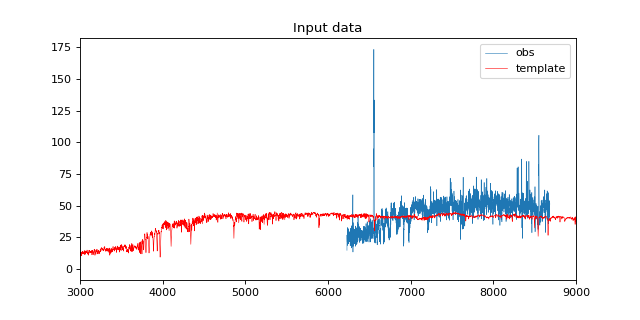

In [7]:
# Note that in this and in subsequent plots, we are showing just the wavelength range of
# interest. The template covers a significantly wider range.
plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.xlim(sp_xlim)
plt.plot(obs.wavelength, obs.flux, linewidth=0.5, label='obs')
plt.plot(template.wavelength, template.flux, linewidth=0.5, color='r', label='template')
plt.legend()
plt.title('Input data')

In [8]:
continuum_model = continuum.fit_generic_continuum(obs) 
p_obs = obs - continuum_model(obs.wavelength)
continuum_model = continuum.fit_generic_continuum(template, model=Chebyshev1D(5)) 
p_template = template - continuum_model(template.wavelength)

Text(0.5, 1.0, 'After continuum subtraction')

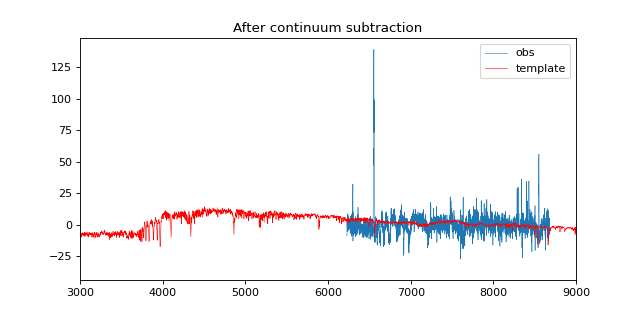

In [9]:
plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.xlim(sp_xlim)
plt.plot(p_obs.wavelength, p_obs.flux, linewidth=0.5, label='obs')
plt.plot(p_template.wavelength, p_template.flux, linewidth=0.5, color='r', label='template')
plt.legend()
plt.title('After continuum subtraction')

In [10]:
# Smooth data with sinc kernel
fc = 0.25  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
b = 0.49   # Transition band, as a fraction of the sampling rate (in (0, 0.5)).

# The IRAF task uses the above values. Here, we try
# a much lower cutoff frequency to really dampen the
# high frequency structure in the observed spectrum.
fc = 0.05 

N = int(np.ceil((4 / b)))
if not N % 2:  # N must be odd
    N += 1
n = np.arange(N)
 
# Compute sinc filter and Blackman window. Multiply filter 
# by window and normalize to get unity gain.
filt = np.sinc(2 * fc * (n - (N - 1) / 2))
w = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + \
    0.08 * np.cos(4 * np.pi * n / (N - 1))
filt *= w
filt /= np.sum(filt)

# Smooth
p_obs_smoothed = convolution_smooth(p_obs, filt)

Text(0.5, 1.0, 'After smoothing')

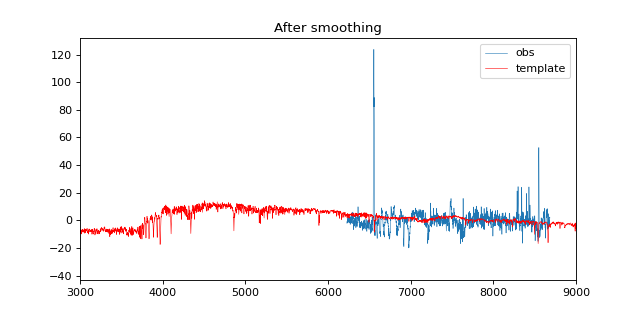

In [11]:
plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.xlim(sp_xlim)
plt.plot(p_obs_smoothed.wavelength, p_obs_smoothed.flux, linewidth=0.5, label='obs')
plt.plot(p_template.wavelength, p_template.flux, linewidth=0.5, color='r', label='template')
plt.legend()
plt.title('After smoothing')

In [12]:
# Correlation. 
#
# With no additional specifications, both the entire template and entire spectrum 
# will be included in the correlation computation. This in general will incur in 
# a significant increase in execution time. It is advised that the template is cut
# to work only on the useful region.

corr, lag = correlation.template_correlate(p_obs_smoothed, p_template)

Text(0.5, 0, 'km / s')

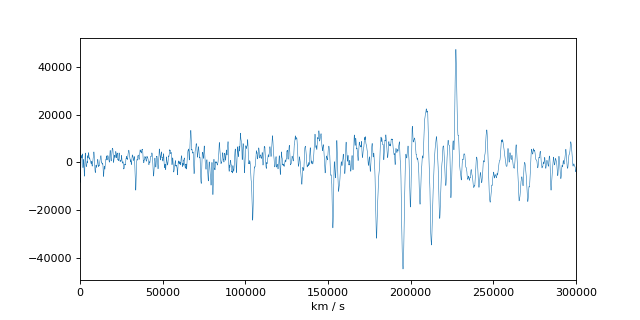

In [13]:
plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.plot(lag, corr, linewidth=0.5)
plt.xlim(0,300000)
plt.xlabel(lag.unit)

In [14]:
# Redshift based on maximum
index_peak = np.where(corr == np.amax(corr))[0][0]
v = lag[index_peak]
z = v / const.c.to('km/s')
print("Peak maximum at: ", v)
print("Redshift from peak maximum: ", z)

Peak maximum at:  227330.87493406623 km / s
Redshift from peak maximum:  0.7582941760798607


In [15]:
# Redshift based on parabolic fit to mazimum

n = 8 # points to the left or right of correlation maximum

peak_lags = lag[index_peak-n:index_peak+n+1].value
peak_vals = corr[index_peak-n:index_peak+n+1].value
p = np.polyfit(peak_lags, peak_vals, deg=2)
roots = np.roots(p)

v_fit = np.mean(roots) * u.km/u.s # maximum lies at mid point between roots
z = v_fit / const.c.to('km/s')

print("Parabolic fit with maximum at: ", v_fit)
print("Redshift from parabolic fit: ", z)

Parabolic fit with maximum at:  227331.80765130284 km / s
Redshift from parabolic fit:  0.7582972872896717


Text(0.5, 1.0, 'Fit to correlation peak')

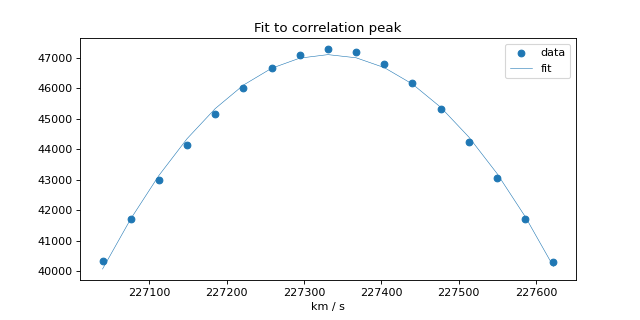

In [16]:
plt.figure()
plt.gcf().set_size_inches((8.,4.))
# plt.xlim(sp_xlim)
plt.scatter(peak_lags, peak_vals, label='data')
plt.plot(peak_lags, np.polyval(p, peak_lags), linewidth=0.5, label='fit')
plt.xlabel(lag.unit)
plt.legend()
plt.title('Fit to correlation peak')

In [17]:
z_ref = 0.758 # "true" redshift, corresponding to 227242.6 km/s

template_z = Spectrum1D(spectral_axis=template.wavelength * (1.+z), flux=template.flux)

Text(0.5, 1.0, 'Redshifted original template and original observed spectrum')

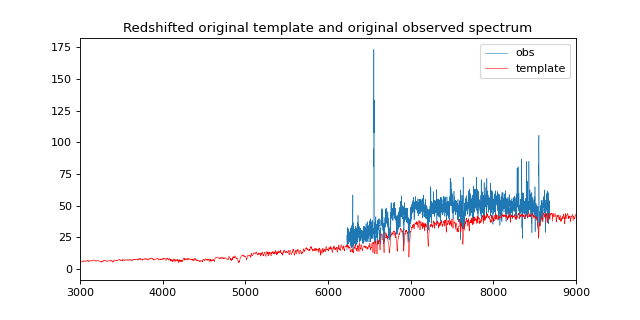

In [18]:
plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.xlim(sp_xlim)
plt.plot(obs.wavelength, obs.flux, linewidth=0.5, label='obs')
plt.plot(template_z.wavelength, template_z.flux, linewidth=0.5, color='r', label='template')
plt.legend()
plt.title('Redshifted original template and original observed spectrum')

In [19]:
z_err = (z - z_ref) / z_ref * 100.
print("Error in the derived redshift: ", z_err, "%")

Error in the derived redshift:  0.039219959059592406 %


In [20]:
# Observation
hdu1d = fits.open(file1d)
hdu1dwht = fits.open(file1dwht)

flux = hdu1d[0].data
wht = hdu1dwht[0].data
unc = 1./ np.sqrt(wht)
wave = np.arange(flux.shape[0])*hdu1d[0].header['CD1_1'] + hdu1d[0].header['CRVAL1']

spec_unit = u.Unit('10^-19 erg s^-1 cm^-2 angstrom^-1')
dataspec = QTable([wave*u.angstrom, flux*spec_unit, wht, unc*spec_unit], 
                   names=('wavelength','flux','weight','uncertainty'))
dataspec_sub = dataspec[dataspec['weight']>0.]
dataspec_sub

/var/folders/z6/bz261yzj6xgdy20gz4lpfn4r00018h/T/ipykernel_2469/1377199938.py:7: RuntimeWarning: divide by zero encountered in true_divide
  unc = 1./ np.sqrt(wht)


wavelength,flux,weight,uncertainty
Angstrom,1e-19 erg / (Angstrom cm2 s),,1e-19 erg / (Angstrom cm2 s)
float64,float32,float32,float32
6229.3,14.757168769836426,0.20703126,2.1977689266204834
6229.900000000001,26.817886352539062,0.14812198,2.5983057022094727
6230.5,23.95525360107422,0.14219064,2.651945114135742
6231.1,22.23990249633789,0.14140277,2.659322738647461
6231.7,22.505369186401367,0.13691239,2.702580213546753
6232.3,21.266435623168945,0.12861502,2.788393974304199
6232.900000000001,21.235198974609375,0.11325585,2.9714584350585938
6233.5,24.18277359008789,0.096821204,3.2137696743011475


In [21]:
# Now make it into a Spectrum1D instance.
obs_orig = Spectrum1D(spectral_axis=dataspec_sub['wavelength'], 
                 flux=dataspec_sub['flux'], 
                 uncertainty=StdDevUncertainty(dataspec_sub['uncertainty']))

In [22]:
# Change resolution of spectrum
obs = gaussian_smooth(obs_orig, stddev=15)

In [23]:
# Template
template = ascii.read(template_file)
factor = 2.E-5 * obs.flux.unit # normalize template to a sensible range
template = Spectrum1D(spectral_axis=template['col1']*u.AA, 
                      flux=template['col2']*factor)

Text(0.5, 1.0, 'Input data')

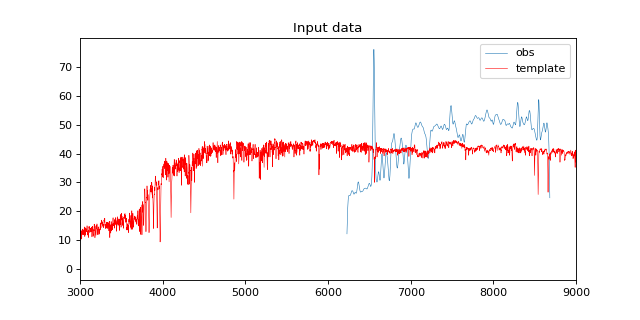

In [24]:
# Note that in this and in subsequent plots, we are showing just the wavelength range of
# interest. The template covers a significantly wider range.
plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.xlim(sp_xlim)
plt.plot(obs.wavelength, obs.flux, linewidth=0.5, label='obs')
plt.plot(template.wavelength, template.flux, linewidth=0.5, color='r', label='template')
plt.legend()
plt.title('Input data')

Text(0.5, 1.0, 'After continuum subtraction')

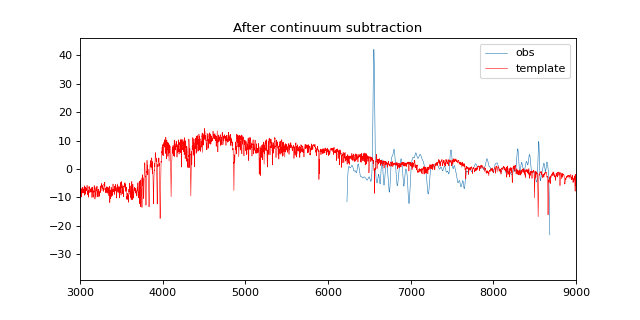

In [25]:
continuum_model = continuum.fit_generic_continuum(obs) 
p_obs = obs - continuum_model(obs.wavelength)
continuum_model = continuum.fit_generic_continuum(template, model=Chebyshev1D(5)) 
p_template = template - continuum_model(template.wavelength)

plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.xlim(sp_xlim)
plt.plot(p_obs.wavelength, p_obs.flux, linewidth=0.5, label='obs')
plt.plot(p_template.wavelength, p_template.flux, linewidth=0.5, color='r', label='template')
plt.legend()
plt.title('After continuum subtraction')

Text(0.5, 1.0, 'After smoothing')

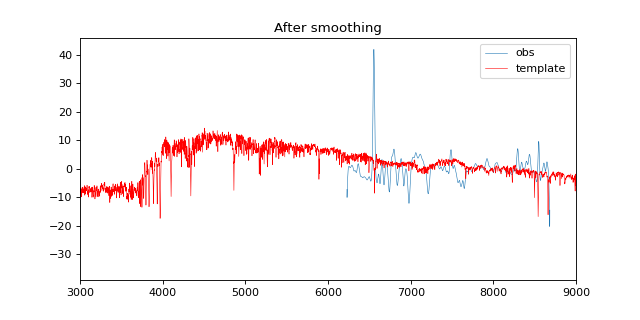

In [26]:
# Smooth data with sinc kernel
fc = 0.25  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
b = 0.49   # Transition band, as a fraction of the sampling rate (in (0, 0.5)).

# The IRAF task uses the above values. Here, we try
# a much lower cutoff frequency to really dampen the
# high frequency structure in the observed spectrum.
fc = 0.05 

N = int(np.ceil((4 / b)))
if not N % 2:  # N must be odd
    N += 1
n = np.arange(N)
 
# Compute sinc filter and Blackman window. Multiply filter 
# by window and normalize to get unity gain.
filt = np.sinc(2 * fc * (n - (N - 1) / 2))
w = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + \
    0.08 * np.cos(4 * np.pi * n / (N - 1))
filt *= w
filt /= np.sum(filt)

# Smooth
p_obs_smoothed = convolution_smooth(p_obs, filt)

plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.xlim(sp_xlim)
plt.plot(p_obs_smoothed.wavelength, p_obs_smoothed.flux, linewidth=0.5, label='obs')
plt.plot(p_template.wavelength, p_template.flux, linewidth=0.5, color='r', label='template')
plt.legend()
plt.title('After smoothing')

Text(0.5, 0, 'km / s')

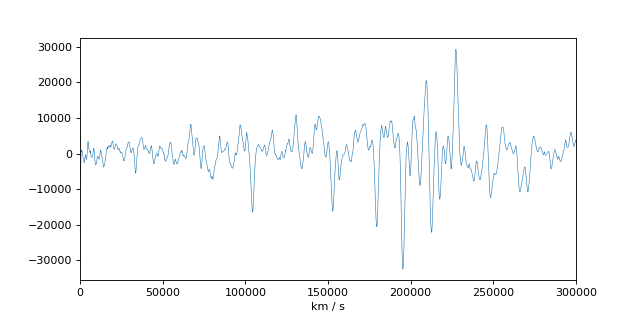

In [27]:
corr, lag = correlation.template_correlate(p_obs_smoothed, p_template)

plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.plot(lag, corr, linewidth=0.5)
plt.xlim(0,300000)
plt.xlabel(lag.unit)

In [28]:
# Redshift based on maximum
index_peak = np.where(corr == np.amax(corr))[0][0]
v = lag[index_peak]
z = v / const.c.to('km/s')
print("Peak maximum at: ", v)
print("Redshift from peak maximum: ", z)

# Redshift based on parabolic fit to mazimum

n = 8 # points to the left or right of correlation maximum

peak_lags = lag[index_peak-n:index_peak+n+1].value
peak_vals = corr[index_peak-n:index_peak+n+1].value
p = np.polyfit(peak_lags, peak_vals, deg=2)
roots = np.roots(p)

v_fit = np.mean(roots) * u.km/u.s # maximum lies at mid point between roots
z = v_fit / const.c.to('km/s')

print("")
print("Parabolic fit with maximum at: ", v_fit)
print("Redshift from parabolic fit: ", z)

Peak maximum at:  227330.87493406623 km / s
Redshift from peak maximum:  0.7582941760798607

Parabolic fit with maximum at:  227368.8280441821 km / s
Redshift from parabolic fit:  0.7584207740282183


Text(0.5, 1.0, 'Redshifted original template and original observed spectrum')

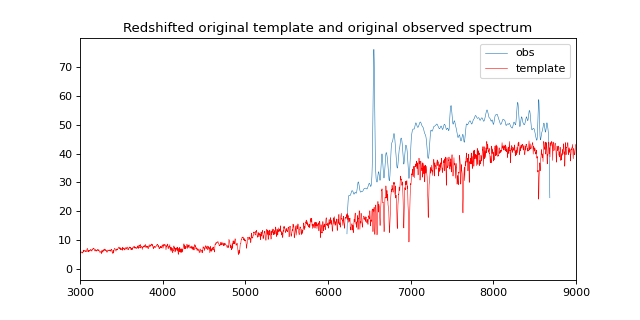

In [29]:
z_ref = 0.758 # "true" redshift, corresponding to 227242.6 km/s

template_z = Spectrum1D(spectral_axis=template.wavelength * (1.+z), flux=template.flux)

plt.figure()
plt.gcf().set_size_inches((8.,4.))
plt.xlim(sp_xlim)
plt.plot(obs.wavelength, obs.flux, linewidth=0.5, label='obs')
plt.plot(template_z.wavelength, template_z.flux, linewidth=0.5, color='r', label='template')
plt.legend()
plt.title('Redshifted original template and original observed spectrum')

In [30]:
z_err = (z - z_ref) / z_ref * 100.
print("Error in the derived redshift: ", z_err, "%")

Error in the derived redshift:  0.05551108551692265 %
